In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import glob
from imageio import imread

from hugeica import *

from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score

import re
from skimage.transform import resize

from data.mvtec import *

np.random.seed(252525)
torch.manual_seed(252525)


In [3]:
def preprocess(X, X_in, X_out, norm_contrast=True, DC=True, channels=None):
    
    X = X.copy()
    X_in = X_in.copy()
    X_out = X_out.copy()
    
    #DEQUANTIZE
    #X_, _ = dequantize(X)
    X_ = X
    
    # CONTRAST
    if norm_contrast:
        X_, _ = to_norm_contrast(X_, DC=DC, channels=channels)
    mean, std = np.zeros(X_.mean(0).shape), X_.std()
    mean, std = X_.mean(), X_.std()

    # SCALE
    X_, _ = scale(X_, mean, std)
    
    #X_in_, _ = dequantize(X_in)
    X_in_ = X_in
    if norm_contrast:
        X_in_, _ = to_norm_contrast(X_in_, DC=DC, channels=channels)
    
    #mean, std = np.zeros(X_in_.mean(0).shape), X_in_.std()
    # mean, std = X_in_.mean(), X_in_.std()
    X_in_, _ = scale(X_in_, mean, std)

    #X_out_, _ = dequantize(X_out)
    X_out_ = X_out
    
    if norm_contrast:
        X_out_, _ = to_norm_contrast(X_out_, DC=DC, channels=channels)
    # mean, std = np.zeros(X_out_.mean(0).shape), X_out_.std()
    # mean, std = X_out_.mean(), X_out_.std()
    X_out_, _ = scale(X_out_, mean, std)
    return X_, X_in_, X_out_, mean, std

def extend_model_(model, n_components, force=False):
    
    assert model.n_tiles >= n_components
    
    if hasattr(model, "extended_components") and not force:
        print("Model already extended with n_components =", model.extended_components)
        return
    
    W = model.model.net.whiten.weight.data
    dev = W.device
    
    model.model.n_components = model.model.n_components + n_components
    model.model.net.whiten.weight.data = torch.cat([model.model.net.whiten.weight.data, torch.ones((n_components, W.shape[1]))]).to(dev)
    model.model.net.whiten.var_expl.data = torch.cat([model.model.net.whiten.var_expl.data, torch.ones(n_components)]).to(dev)
    model.model.net.ica.weight.data = torch.eye(W.shape[0] + n_components).to(dev)
    
    model.extended_components = n_components


def patch_model_(model, X_ref, x, n_components=3):
    
    k = len(model.model.net.whiten.var_expl.data)
    model.model.net.whiten.var_expl.data[-n_components:] = torch.ones(n_components)
    
    model2 = SFA(shape=model.shape, 
                BSZ=model.BSZ, 
                stride=model.stride, 
                n_components=n_components,
                remove_components=0,
                max_components=100,
                min_components=2,
                mode="ta",
                use_conv=False,
                inter_image_diffs=False,
                extended_entropies=False)
    model2.fit(x, 1, bs=15000, lr=1e-4, logging=-1)
    
    W_new = model2.model.net.whiten.weight.data
    
    model.model.net.whiten.weight.data[-n_components:, :] = W_new[:n_components, :]
    batch = model.transform(np.asarray(X_ref), agg="none").reshape(-1, k)
    variance = batch.var(0)
    model.model.net.whiten.var_expl.data[-n_components:] = torch.from_numpy(variance[-n_components:])

    
def extended_scores(model, X_ref, X_test, n_components=3):
    
    extend_model_(model, n_components)
    
    scores = []
    
    for i in range(len(X_test)):
        
        x = X_test[i:i+1]
        
        patch_model_(model, X_ref, x, n_components)
        score = model.transform(np.asarray(x), agg="mean").flatten()
        scores.append(score)
        
    return np.asarray(scores)
        
    

In [ ]:
log_full = []
for clazz in range(7, len(MVTEC.CLASSES)):

    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)
    
    X_ = X_[np.random.permutation(75)] if len(X_) > 75 else X_
   
    hyp2 = SFA.hyperparameter_search(X_, X_valid_, X_test_,
                      patch_size=range(14, 15*14, 28),
                      n_components=["q95"], 
                      stride=[14], 
                      shape=(3, 224, 224), 
                      bs=15000, 
                      lr=1e-4,
                      epochs=20,
                      norm=[2],
                      mode="ta",
                      max_components=85,
                      min_components=10,
                      remove_components=[0],
                      use_conv=False,
                      logging=-1, 
                      aucs=["mean", "avg_patch_reconstruct", "avg_reconstruct"],
                      compute_bpd=False) 
    display(hyp2)
    log_full.append(hyp2)
    print(clazz)
        
concat = pd.concat(log_full)
concat["class"] = np.repeat(np.arange(len(log_full)), len(log_full[0]))
concat.to_csv(f"./experiments/mvtec_hyperparameter_search_q90_ta_full_bpd.csv")

# Fit SpatialICA(q95).


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_SO.py:46: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  self.weight.data = torch.qr(torch.distributions.Normal(0,0.01).sample(self.weight.data.shape))[0]


# Fit HugeICA((29696, 588, 85), device='cuda', bs=14848)


/home/matthias/Desktop/workspace/fasterica/hugeica/helpers/expm32.py:262: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return torch.solve(P, Q)[0]


# Re-Fit SpatialICA(80).
# Fit HugeICA((29696, 588, 80), device='cuda', bs=14848)
# Compute ICA metrics.
# Fit SFA(80).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((14700, 5292, 85), device='cuda', bs=14896)
# Re-Fit SpatialICA(80).
# Fit HugeICA((14700, 5292, 80), device='cuda', bs=14896)
# Compute ICA metrics.
# Fit SFA(80).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((10800, 14700, 85), device='cuda', bs=14976)
# Re-Fit SpatialICA(80).
# Fit HugeICA((10800, 14700, 80), device='cuda', bs=14976)
# Compute ICA metrics.
# Fit SFA(80).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((7500, 28812, 85), device='cuda', bs=15000)
# Re-Fit SpatialICA(80).
# Fit HugeICA((7500, 28812, 80), device='cuda', bs=15000)
# Compute ICA metrics.
# Fit SFA(80).
# Compute Information Measure

,patch_size,s,n_components,nor,remove_components,k_min,k_max,k,kurt,bpd,...,d_ruzsa,d_ruzsa_,negH_diff,negH_diff_avg,negH_sum,H_max,lhd,mean,avg_patch_reconstruct,avg_reconstruct
0,14.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.013245,0.0,...,0.0,0.0,0.000940,0.000012,0.292817,2.819179,0.0,0.339545,0.427536,0.455487
1,42.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,-0.001434,0.0,...,0.0,0.0,0.001242,0.000017,0.269156,2.829953,0.0,0.450311,0.447205,0.415114
2,70.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.000947,0.0,...,0.0,0.0,0.001749,0.000021,0.281453,2.830139,0.0,0.632505,0.419255,0.448240
3,98.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,-0.012822,0.0,...,0.0,0.0,0.002710,0.000031,0.256601,2.828724,0.0,0.550725,0.392340,0.468944
4,126.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,-0.003235,0.0,...,0.0,0.0,0.003865,0.000049,0.254099,NaN,0.0,0.519669,0.385093,0.501035
5,154.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,-0.007953,0.0,...,0.0,0.0,0.006507,0.000087,0.266600,NaN,0.0,0.577640,0.406832,0.549689
6,182.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.009176,0.0,...,0.0,0.0,0.015215,0.000197,0.259385,NaN,0.0,0.557971,0.443064,0.527950


7
# Fit SpatialICA(q95).
# Fit HugeICA((29696, 588, 85), device='cuda', bs=14848)
# Re-Fit SpatialICA(10).
# Fit HugeICA((29696, 588, 10), device='cuda', bs=14848)
# Compute ICA metrics.
# Fit SFA(10).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((11760, 5292, 85), device='cuda', bs=14896)
# Re-Fit SpatialICA(11).
# Fit HugeICA((11760, 5292, 11), device='cuda', bs=14896)
# Compute ICA metrics.
# Fit SFA(11).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((8640, 14700, 85), device='cuda', bs=14976)
# Re-Fit SpatialICA(17).
# Fit HugeICA((8640, 14700, 17), device='cuda', bs=14976)
# Compute ICA metrics.
# Fit SFA(17).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((6000, 28812, 85), device='cuda', bs=15000)
# Re-Fit SpatialICA(19).
# Fit HugeICA((6000, 28812, 19), device='cuda

,patch_size,s,n_components,nor,remove_components,k_min,k_max,k,kurt,bpd,...,d_ruzsa,d_ruzsa_,negH_diff,negH_diff_avg,negH_sum,H_max,lhd,mean,avg_patch_reconstruct,avg_reconstruct
0,14.0,14.0,10.0,2.0,0.0,0.0,0.0,0.0,9.812418,0.0,...,0.0,0.0,0.156361,0.015560,0.040237,0.946232,0.0,0.541667,0.555556,0.602778
1,42.0,14.0,11.0,2.0,0.0,0.0,0.0,0.0,2.685634,0.0,...,0.0,0.0,0.042269,0.003857,0.048416,1.581218,0.0,0.527778,0.491667,0.586111
2,70.0,14.0,17.0,2.0,0.0,0.0,0.0,0.0,0.768995,0.0,...,0.0,0.0,0.011820,0.000707,0.082067,1.755278,0.0,0.538889,0.530556,0.691667
3,98.0,14.0,19.0,2.0,0.0,0.0,0.0,0.0,1.671183,0.0,...,0.0,0.0,0.029180,0.001620,0.080553,1.876398,0.0,0.555556,0.538889,0.619444
4,126.0,14.0,20.0,2.0,0.0,0.0,0.0,0.0,3.376352,0.0,...,0.0,0.0,0.083539,0.004122,0.081032,NaN,0.0,0.569444,0.577778,0.716667
5,154.0,14.0,21.0,2.0,0.0,0.0,0.0,0.0,3.037863,0.0,...,0.0,0.0,0.106374,0.005005,0.090269,NaN,0.0,0.580556,0.652778,0.833333
6,182.0,14.0,14.0,2.0,0.0,0.0,0.0,0.0,2.073247,0.0,...,0.0,0.0,0.061683,0.004306,0.058083,NaN,0.0,0.605556,0.744444,0.880556


8
# Fit SpatialICA(q95).
# Fit HugeICA((29696, 588, 85), device='cuda', bs=14848)
# Re-Fit SpatialICA(80).
# Fit HugeICA((29696, 588, 80), device='cuda', bs=14848)
# Compute ICA metrics.
# Fit SFA(80).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((14700, 5292, 85), device='cuda', bs=14896)
# Re-Fit SpatialICA(80).
# Fit HugeICA((14700, 5292, 80), device='cuda', bs=14896)
# Compute ICA metrics.
# Fit SFA(80).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((10800, 14700, 85), device='cuda', bs=14976)
# Re-Fit SpatialICA(80).
# Fit HugeICA((10800, 14700, 80), device='cuda', bs=14976)
# Compute ICA metrics.
# Fit SFA(80).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((7500, 28812, 85), device='cuda', bs=15000)
# Re-Fit SpatialICA(80).
# Fit HugeICA((7500, 28812, 80), device='cu

,patch_size,s,n_components,nor,remove_components,k_min,k_max,k,kurt,bpd,...,d_ruzsa,d_ruzsa_,negH_diff,negH_diff_avg,negH_sum,H_max,lhd,mean,avg_patch_reconstruct,avg_reconstruct
0,14.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.619183,0.0,...,0.0,0.0,0.020570,0.000255,0.291152,2.817688,0.0,0.579307,0.665966,0.534139
1,42.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.249925,0.0,...,0.0,0.0,0.003639,0.000046,0.262386,2.888136,0.0,0.534926,0.693277,0.555147
2,70.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.185973,0.0,...,0.0,0.0,0.002813,0.000035,0.266254,2.907382,0.0,0.597164,0.678834,0.538603
3,98.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.210621,0.0,...,0.0,0.0,0.003920,0.000048,0.251439,2.912157,0.0,0.448529,0.652048,0.536765
4,126.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.299837,0.0,...,0.0,0.0,0.006695,0.000089,0.262549,NaN,0.0,0.527836,0.642595,0.529674
5,154.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.476092,0.0,...,0.0,0.0,0.013364,0.000163,0.287326,NaN,0.0,0.570641,0.660977,0.518908
6,182.0,14.0,80.0,2.0,0.0,0.0,0.0,0.0,0.367017,0.0,...,0.0,0.0,0.020253,0.000231,0.257462,NaN,0.0,0.475840,0.684611,0.569853


9
# Fit SpatialICA(q95).
# Fit HugeICA((29696, 588, 85), device='cuda', bs=14848)
# Re-Fit SpatialICA(10).
# Fit HugeICA((29696, 588, 10), device='cuda', bs=14848)
# Compute ICA metrics.
# Fit SFA(10).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((14700, 5292, 85), device='cuda', bs=14896)
# Re-Fit SpatialICA(10).
# Fit HugeICA((14700, 5292, 10), device='cuda', bs=14896)
# Compute ICA metrics.
# Fit SFA(10).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((10800, 14700, 85), device='cuda', bs=14976)
# Re-Fit SpatialICA(13).
# Fit HugeICA((10800, 14700, 13), device='cuda', bs=14976)
# Compute ICA metrics.
# Fit SFA(13).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((7500, 28812, 85), device='cuda', bs=15000)
# Re-Fit SpatialICA(20).
# Fit HugeICA((7500, 28812, 20), device='cu

,patch_size,s,n_components,nor,remove_components,k_min,k_max,k,kurt,bpd,...,d_ruzsa,d_ruzsa_,negH_diff,negH_diff_avg,negH_sum,H_max,lhd,mean,avg_patch_reconstruct,avg_reconstruct
0,14.0,14.0,10.0,2.0,0.0,0.0,0.0,0.0,19.232079,0.0,...,0.0,0.0,0.306845,0.030739,0.043804,0.655195,0.0,0.333067,0.630634,0.470682
1,42.0,14.0,10.0,2.0,0.0,0.0,0.0,0.0,9.813068,0.0,...,0.0,0.0,0.194542,0.019483,0.059790,1.174485,0.0,0.289988,0.618269,0.497407
2,70.0,14.0,13.0,2.0,0.0,0.0,0.0,0.0,4.959412,0.0,...,0.0,0.0,0.098500,0.007606,0.078531,1.506984,0.0,0.329876,0.633027,0.434783
3,98.0,14.0,20.0,2.0,0.0,0.0,0.0,0.0,1.525197,0.0,...,0.0,0.0,0.036793,0.001832,0.122323,1.574351,0.0,0.396091,0.615876,0.424013
4,126.0,14.0,22.0,2.0,0.0,0.0,0.0,0.0,0.538356,0.0,...,0.0,0.0,0.039097,0.001761,0.108584,NaN,0.0,0.456322,0.511368,0.451935
5,154.0,14.0,16.0,2.0,0.0,0.0,0.0,0.0,1.359553,0.0,...,0.0,0.0,0.054511,0.003426,0.088216,NaN,0.0,0.447148,0.519745,0.546071
6,182.0,14.0,10.0,2.0,0.0,0.0,0.0,0.0,0.271795,0.0,...,0.0,0.0,0.025571,0.002871,0.046818,NaN,0.0,0.454727,0.549262,0.600319


10
# Fit SpatialICA(q95).
# Fit HugeICA((29696, 588, 85), device='cuda', bs=14848)
# Re-Fit SpatialICA(10).
# Fit HugeICA((29696, 588, 10), device='cuda', bs=14848)
# Compute ICA metrics.
# Fit SFA(10).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((14700, 5292, 85), device='cuda', bs=14896)
# Re-Fit SpatialICA(10).
# Fit HugeICA((14700, 5292, 10), device='cuda', bs=14896)
# Compute ICA metrics.
# Fit SFA(10).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((10800, 14700, 85), device='cuda', bs=14976)
# Re-Fit SpatialICA(11).
# Fit HugeICA((10800, 14700, 11), device='cuda', bs=14976)
# Compute ICA metrics.
# Fit SFA(11).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((7500, 28812, 85), device='cuda', bs=15000)
# Re-Fit SpatialICA(16).
# Fit HugeICA((7500, 28812, 16), device='c

,patch_size,s,n_components,nor,remove_components,k_min,k_max,k,kurt,bpd,...,d_ruzsa,d_ruzsa_,negH_diff,negH_diff_avg,negH_sum,H_max,lhd,mean,avg_patch_reconstruct,avg_reconstruct
0,14.0,14.0,10.0,2.0,0.0,0.0,0.0,0.0,12.263145,0.0,...,0.0,0.0,0.166490,0.016755,0.032989,0.476768,0.0,0.550000,0.796429,0.804643
1,42.0,14.0,10.0,2.0,0.0,0.0,0.0,0.0,2.723862,0.0,...,0.0,0.0,0.030186,0.002955,0.034119,1.177005,0.0,0.509643,0.830357,0.765357
2,70.0,14.0,11.0,2.0,0.0,0.0,0.0,0.0,2.190730,0.0,...,0.0,0.0,0.023814,0.002115,0.036434,1.482238,0.0,0.527857,0.829286,0.588571
3,98.0,14.0,16.0,2.0,0.0,0.0,0.0,0.0,1.630802,0.0,...,0.0,0.0,0.034175,0.002138,0.062982,1.487820,0.0,0.504286,0.847143,0.543214
4,126.0,14.0,20.0,2.0,0.0,0.0,0.0,0.0,0.845463,0.0,...,0.0,0.0,0.030813,0.001646,0.058473,NaN,0.0,0.491429,0.845357,0.520000
5,154.0,14.0,26.0,2.0,0.0,0.0,0.0,0.0,0.744146,0.0,...,0.0,0.0,0.017896,0.000701,0.092171,NaN,0.0,0.510714,0.838571,0.565357
6,182.0,14.0,34.0,2.0,0.0,0.0,0.0,0.0,0.401359,0.0,...,0.0,0.0,0.017236,0.000505,0.126376,NaN,0.0,0.584286,0.812857,0.622143


11
# Fit SpatialICA(q95).
# Fit HugeICA((29696, 588, 85), device='cuda', bs=14848)
# Re-Fit SpatialICA(23).
# Fit HugeICA((29696, 588, 23), device='cuda', bs=14848)
# Compute ICA metrics.
# Fit SFA(23).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((14700, 5292, 85), device='cuda', bs=14896)
# Re-Fit SpatialICA(43).
# Fit HugeICA((14700, 5292, 43), device='cuda', bs=14896)
# Compute ICA metrics.
# Fit SFA(43).
# Compute Information Measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((10800, 14700, 85), device='cuda', bs=14976)
# Re-Fit SpatialICA(53).
# Fit HugeICA((10800, 14700, 53), device='cuda', bs=14976)


In [62]:
log = pd.read_csv("./experiments/mvtec_hyperparameter_search_q90_ta_full.csv")

df = []
for i in range(15):
    l = log[log["class"] == i]
    l = l[l["nor"] == 2]
    df.append((l.sort_values("negH_sum", ascending=False)["mean"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["n_components"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["negH_sum"].head(1).item()))

display(pd.DataFrame(df, columns=["score", "patch_size", "k", "-H"] ))
pd.DataFrame([np.asarray(df).mean(0)[0]], columns=["mean score"] )


,score,patch_size,k,-H
0,0.699206,98.0,73.0,0.240807
1,0.532504,154.0,56.0,0.267329
2,0.586045,182.0,48.0,0.268433
3,0.557010,182.0,56.0,0.176369
4,0.635417,182.0,70.0,0.391641
5,0.915790,182.0,69.0,0.748121
6,0.752062,126.0,57.0,0.183001
7,0.466874,14.0,80.0,0.255460
8,0.561111,126.0,20.0,0.094842
9,0.601891,182.0,80.0,0.253723


,mean score
0,0.609087


In [ ]:
bs = 50
t = 74 # tile_size
p = 3 # fallback patch_size
s = s # stride

log = []

for clazz in range(0, 15):
    
    model_scores_in1 = []
    model_scores_out1 = []

    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)

    n_tiles = X_.shape[2] // t
    print("Starting: n_tiles", n_tiles**2)

    shapes = (X_.shape, X_test_.shape, X_valid_.shape)
    c = X_.shape[1]
    tt = 0.

    for i in range(n_tiles):
        for j in range(n_tiles):

            X = X_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            
            if True:
                hyp = SFA.hyperparameter_search(X, X_in, X_out, 
                              patch_size=[14, 3*14, 5*14],
                              n_components=[ "q90" ], 
                              stride=[s], 
                              shape=(c, t, t), 
                              bs=5000, 
                              epochs=1,
                              remove_components = [0],
                              max_components=200,
                              min_components=10,
                              norm=[2], 
                              mode="ta", 
                              compute_bpd = False,
                              aucs=["mean", "sum"],
                              preprocess = preprocessing) 
                p_size = int( hyp.sort_values("negH_sum", ascending=True)["patch_size"].head(1).item() )
                print(p_size)
                
                display(hyp)
            else:
                p_size = p

            model = SFA(shape=(c, t, t), 
                            BSZ=(p_size, p_size), 
                            stride=s, 
                            n_components="q90",
                            remove_components=0,
                            max_components=5000,
                            min_components=10,
                            mode="ta")

            model.fit(X, 1, bs=5000, lr=1e-3, logging=-1)

            t0 = time.time()
            S_in = model.transform(np.asarray(X_in), agg="mean")
            S_out = model.transform(np.asarray(X_out), agg="mean")
            model_scores_in1.append(S_in)
            model_scores_out1.append(S_out)
            tt += (time.time() - t0)

    score_in1 = np.linalg.norm( np.hstack(model_scores_in1), axis=1)
    score_out1 = np.linalg.norm( np.hstack(model_scores_out1), axis=1)
    auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))
    
    fps = (len(score_in1) + len(score_out1)) / tt
    ms = tt / (len(score_in1) + len(score_out1)) * 1000
    
    df = pd.DataFrame(np.asarray([clazz, auc1, fps, ms])[:, None].T, columns=["class", "AUC", "fps", "ms"]) 
    log.append(df)
    
    display(pd.concat(log))

In [109]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(5, P=224, s=224)

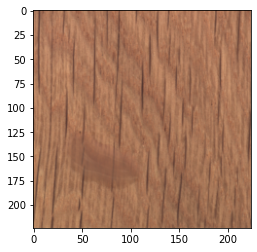

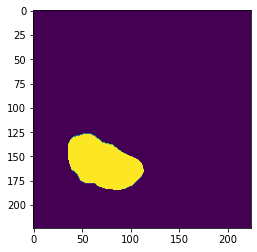

In [110]:
idx = np.random.randint(len(X_test_))
plt.imshow(X_test_[idx].transpose(1,2,0))
plt.show()
plt.imshow(X_labels_[idx].transpose(1,2,0))

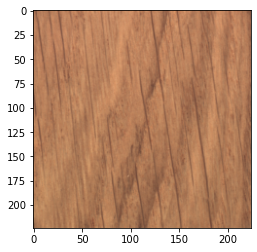

In [111]:
idx = np.random.randint(len(X_valid_))
plt.imshow(X_valid_[idx].transpose(1,2,0))

In [106]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(0, P=56, s=56, label_per_patch=False)

X_, X_in_, X_out_, mean, std = preprocess(X_, X_valid_, X_test_)

In [116]:
model = SFA(shape=(3, 56, 56), 
                BSZ=(28, 28), 
                stride=14, 
                n_components="q90",
                remove_components=0,
                max_components=85,
                mode="ta",
                use_conv=False,
                inter_image_diffs=False,
                extended_entropies=False)
model.fit(X_, 20, bs=15000, lr=1e-4, logging=-1)

# Fit SpatialICA(q90).
# Fit HugeICA((44982, 2352, 85), device='cuda', bs=14994)
# Re-Fit SpatialICA(38).
# Fit HugeICA((44982, 2352, 38), device='cuda', bs=14994)
# Compute ICA metrics.
# Fit SFA(38).
# Compute information measures


In [121]:
S_in = np.linalg.norm( model.transform(np.asarray(X_in_), agg="mean") , axis=1).reshape(-1, 16).min(1)
S_out = np.linalg.norm(  model.transform(np.asarray(X_out_), agg="mean"), axis=1).reshape(-1, 16).min(1)
        
roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([S_in, S_out]))

0.665873015873016

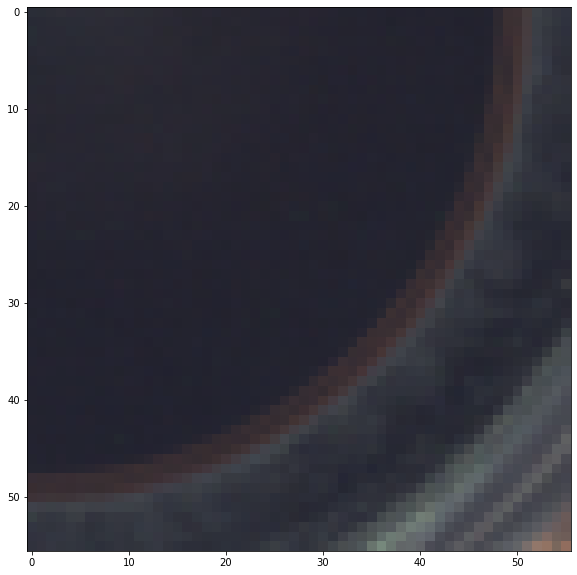

In [108]:
plt.imshow(X_valid_[10].transpose(1,2,0))

In [124]:
from sklearn.neighbors import NearestNeighbors

nrs = NearestNeighbors(n_neighbors=1)
nrs.fit( model.transform(np.asarray(X_), agg="none").reshape(-1, model.n_components) )

S_in= nrs.kneighbors(model.transform(np.asarray(X_in_), agg="none").reshape(-1, model.n_components), return_distance=True)[0]
S_out = nrs.kneighbors(model.transform(np.asarray(X_out_), agg="none").reshape(-1, model.n_components), return_distance=True)[0]

S_in = S_in.reshape(len(X_in_), -1).mean(1)
S_out = S_out.reshape(len(X_out_), -1).mean(1)

roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([S_in, S_out]))

0.5120520213293651

In [132]:
from sklearn.neighbors import NearestNeighbors

nrs = NearestNeighbors(n_neighbors=1)
nrs.fit( X_.reshape(len(X_), -1) )

S_in = nrs.kneighbors(X_in_.reshape(len(X_in_), -1), return_distance=True)[0].reshape(-1, 16).mean(1)
S_out = nrs.kneighbors(X_out_.reshape(len(X_out_), -1), return_distance=True)[0].reshape(-1, 16).mean(1)

roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([S_in, S_out]))

0.7968253968253969

# Investigate Model Extension

In [125]:
extend_model_(model, 5, force=False)

In [126]:
%%capture
S_in = extended_scores(model, X_, X_in_, n_components=5)
S_out = extended_scores(model, X_, X_out_, n_components=5)

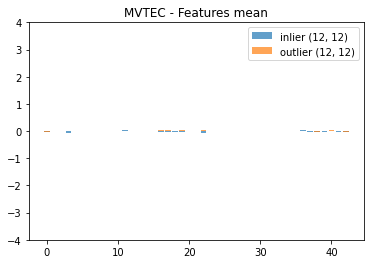

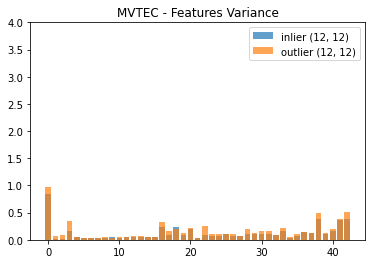

auc 0.5241195436507937


In [72]:
auc = roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([np.linalg.norm(S_in, axis=1, ord=2), np.linalg.norm(S_out, axis=1, ord=2)]))

S0 = model.transform(np.asarray(X_in_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_out_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), S0.mean(1).mean(0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), S0_.mean(1).mean(0), label="outlier (12, 12)", alpha=0.7 )
plt.ylim(-4, 4)
plt.legend()
plt.title(f"MVTEC - Features mean")
plt.show()


S0 = model.transform(np.asarray(X_in_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_out_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), S0.mean(1).var(0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), S0_.mean(1).var(0), label="outlier (12, 12)", alpha=0.7 )
plt.ylim(0, 4)
plt.legend()
plt.title(f"MVTEC - Features Variance")
plt.show()

print("auc", auc)

In [131]:
from sklearn.neighbors import NearestNeighbors

nrs = NearestNeighbors(n_neighbors=1)
nrs.fit( model.transform(np.asarray(X_), agg="none").reshape(-1, model.n_components + model.extended_components) )

S_in= nrs.kneighbors(model.transform(np.asarray(X_in_), agg="none").reshape(-1, model.n_components + model.extended_components), return_distance=True)[0]
S_out = nrs.kneighbors(model.transform(np.asarray(X_out_), agg="none").reshape(-1, model.n_components+ model.extended_components), return_distance=True)[0]

S_in = S_in.reshape(len(X_in_), -1).mean(1)
S_out = S_out.reshape(len(X_out_), -1).mean(1)

roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([S_in, S_out]))

0.5649522569444444

# Inspect Mean-Shift

# Fit SpatialICA(q95).
# Fit HugeICA((675, 132300, 75), device='cuda', bs=14994)
  0%|                                                                                                                                                                                                                                   | 0/1 [00:01<?, ?it/s]
Ep.  0 - -1.0101 - validation (loss/white/kurt/mi/logp): -0.9378 / 0.00 / 0.76 / 0.0194 / 0.4039 (eval took: 0.0s)
# Re-Fit SpatialICA(56).
# Fit HugeICA((675, 132300, 56), device='cuda', bs=14994)
  0%|                                                                                                                                                                                                                                   | 0/1 [00:01<?, ?it/s]
Ep.  0 - -1.0101 - validation (loss/white/kurt/mi/logp): -0.9379 / 0.00 / 0.93 / 0.0192 / 0.4012 (eval took: 0.0s)
Ep.  1 - -0.9379 - validation (loss/white/kurt/mi/logp): -0.9380 / 0.00 / 0.94 / 0.0195 / 0.4012

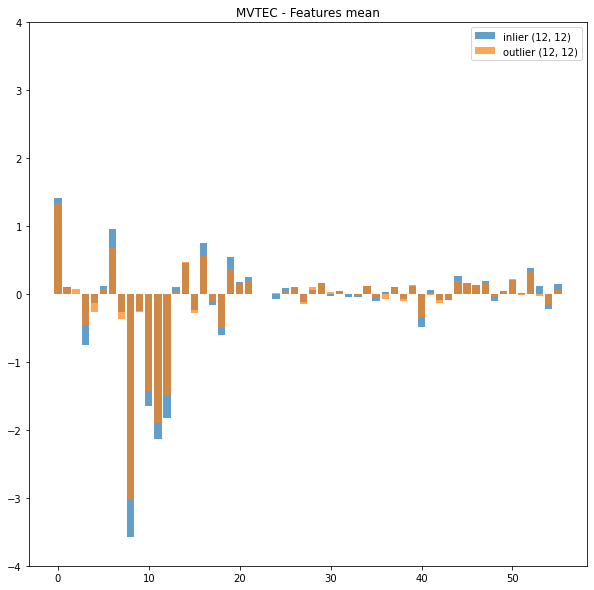

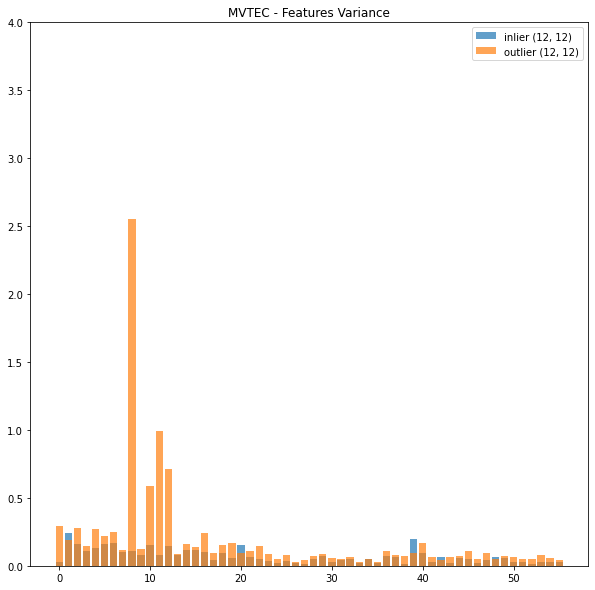

auc 0.5393258426966292 0.27141413


In [19]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(1, P=224, s=224, label_per_patch=False)
X_ref_, X_in_, X_out_, mean, std = preprocess(X_, X_valid_, X_test_, norm_contrast=True, DC=True, channels=None)

X_ref_ = X_ref_[:75]

m = 15 
t = 1 
model = SFA(shape=(3, 224, 224), 
                BSZ=(m*14, m*14), 
                stride=t*7, 
                n_components="q95",
                remove_components=0,
                max_components=75,
                min_components=10,
                mode="ta",
                use_conv=False,
                inter_image_diffs=False,
                extended_entropies=False)
model.fit(X_ref_, 20, bs=15000, lr=1e-4, logging=1)


# X_in_ = X_ref_[:32]

S_in = model.transform(np.asarray(X_in_), agg="mean")
S_out = model.transform(np.asarray(X_out_), agg="mean")
        
auc = roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([np.linalg.norm(S_in, axis=1, ord=2), np.linalg.norm(S_out, axis=1, ord=2)]))

S0 = model.transform(np.asarray(X_in_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_out_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), S0.mean(1).mean(0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), S0_.mean(1).mean(0), label="outlier (12, 12)", alpha=0.7 )
plt.ylim(-4, 4)
plt.legend()
plt.title(f"MVTEC - Features mean")
plt.show()


S0 = model.transform(np.asarray(X_in_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_out_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), S0.mean(1).var(0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), S0_.mean(1).var(0), label="outlier (12, 12)", alpha=0.7 )
plt.ylim(0, 4)
plt.legend()
plt.title(f"MVTEC - Features Variance")
plt.show()

print("auc", auc, model.negH_sum)
# matplotlib2tikz.save(f"CIFAR_{class_name}_mean.tex")

In [80]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(0, P=56, s=56, label_per_patch=False)

X_.mean(), X_valid_.mean(), X_test_.mean(), X_.std(), X_valid_.std(), X_test_.std()

(0.5383623, 0.54334104, 0.5433122, 0.3602515, 0.35897103, 0.35668182)

In [81]:
X_ref_, X_in_, X_out_, mean, std = preprocess(X_, X_valid_, X_test_, norm_contrast=True, DC=True, channels=None)

X_ref_.mean(), X_in_.mean(), X_out_.mean()

(-9.327837e-09, -9.214392e-09, -8.595401e-09)

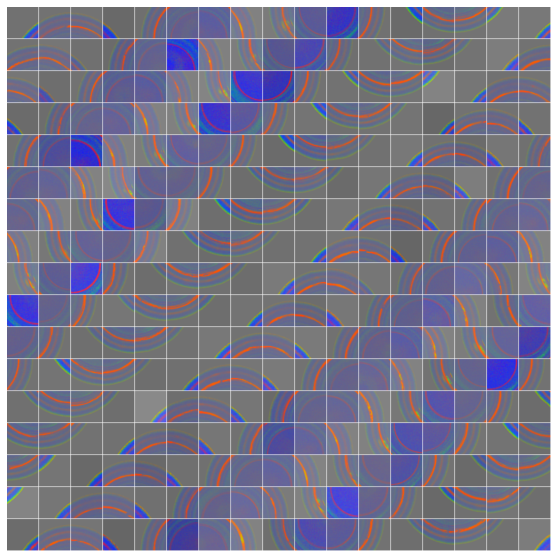

In [82]:
plt.rcParams["figure.figsize"] = (10, 10)

show_filters_color(X_ref_[:len(X_in_)].reshape(len(X_in_), -1).T, C=3)

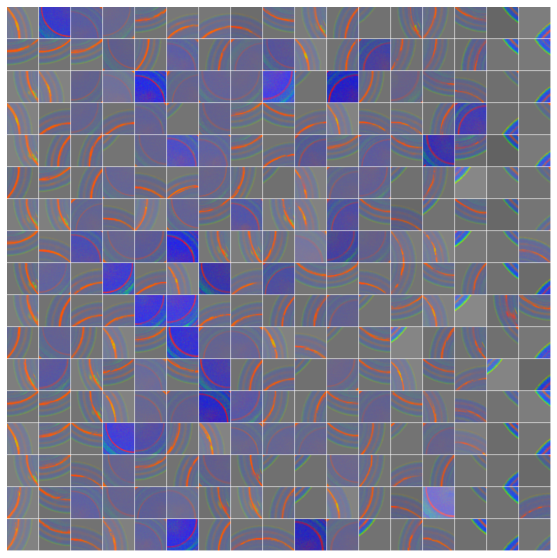

In [83]:
outlier_order = np.argsort(np.linalg.norm( model.transform(np.asarray(X_in_), agg="mean") , axis=1))[::-1]
show_filters_color(X_in_[outlier_order].reshape(len(outlier_order), -1).T, C=3)

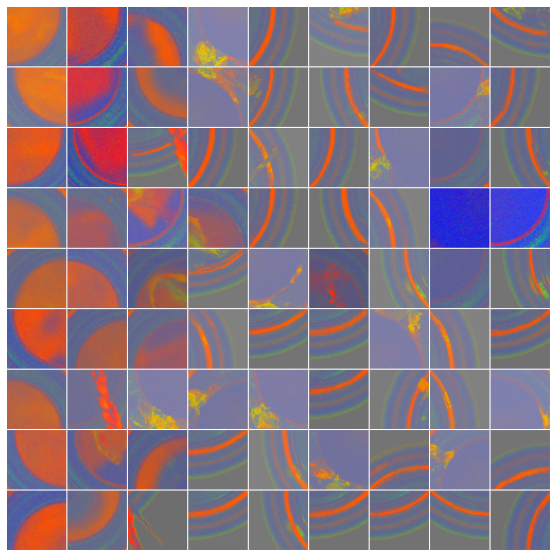

In [86]:
fpr = 5

scores_inlier = np.linalg.norm( model.transform(np.asarray(X_in_), agg="mean") , axis=1)
thresh = np.percentile(scores_inlier, 100 - fpr)

scores = np.linalg.norm( model.transform(np.asarray(X_out_), agg="mean") , axis=1)
outlier_order = np.argsort(scores)[::-1]
subset = X_out_[outlier_order]
scores = scores[outlier_order]

subset = subset[scores > thresh]

subset = subset.reshape(len(subset), -1)
show_filters_color(subset.T, C=3)